In [13]:
#Import necessary libraries
#Handle data frames
import pandas as pd
#Handle geo data frames (data frames with geometry)
import geopandas as gpd
#Operations on geometries
import shapely
from shapely.geometry import Polygon, Point
from shapely import speedups
from shapely.ops import unary_union
#Fast vectorized operations
import shapely.vectorized as sv
#Arrays and maths
import numpy as np
import math
#Handle netCDF4 data
import xarray as xr
#Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.ticker as mticker
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import metpy.calc as mpcalc
import seaborn as sns
#Interactive plots
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from datetime import datetime
from os import listdir
from openpyxl.workbook import Workbook
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')
#sns.set()
sns.set(style='ticks') #for PV and IVT plots
%matplotlib inline

In [2]:
#Define paths for Hydrobasin and Precipitation data
event = 'EU_1'
path = "C:/Users/Jérôme/Documents/Master UniBe/Cours/Master Thesis/Data/Hydrobasin"
path2 = "C:/Users/Jérôme/Documents/Master UniBe/Cours/Master Thesis/Data/World/ERA5"
path3 = 'C:/Data/Pfiles/'
#Path to Hydrobasin data
path_HB = "..."
#Path to files with clustering episodes:
#(eps_rY_tZ_wW_XX, XX = HydroBASINS regions, Y = run length in days) Z = threshold, W = time window)
#accumulation (tw_rY_XX), quantiles (quantiles_XX) and grids (Catchments_Grid_XX_025dg_lv6)
path = "..."
#Path to files for PV and IVT plot (Figure 11)
path_ex = "..."

In [3]:
#Create Hydrobasin world map
hybas_af = gpd.read_file(path_HB + "/hybas_lake_af_lev01-06_v1c/hybas_lake_af_lev06_v1c.shp")
hybas_ar = gpd.read_file(path_HB + "/hybas_lake_ar_lev01-06_v1c/hybas_lake_ar_lev06_v1c.shp")
hybas_as = gpd.read_file(path_HB + "/hybas_lake_as_lev01-06_v1c/hybas_lake_as_lev06_v1c.shp")
hybas_au = gpd.read_file(path_HB + "/hybas_lake_au_lev01-06_v1c/hybas_lake_au_lev06_v1c.shp")
hybas_eu = gpd.read_file(path_HB + "/hybas_lake_eu_lev01-06_v1c/hybas_lake_eu_lev06_v1c.shp")
hybas_gr = gpd.read_file(path_HB + "/hybas_lake_gr_lev01-06_v1c/hybas_lake_gr_lev06_v1c.shp")
hybas_na = gpd.read_file(path_HB + "/hybas_lake_na_lev01-06_v1c/hybas_lake_na_lev06_v1c.shp")
hybas_sa = gpd.read_file(path_HB + "/hybas_lake_sa_lev01-06_v1c/hybas_lake_sa_lev06_v1c.shp")
hybas_si = gpd.read_file(path_HB + "/hybas_lake_si_lev01-06_v1c/hybas_lake_si_lev06_v1c.shp")
#Select only the necessary columns from Hydrobasin dataframe
hybas_data = hybas_af.append([hybas_ar,hybas_as,hybas_au,hybas_eu,hybas_gr,hybas_na,hybas_sa,hybas_si])
hybas_data_gdf = hybas_data[['HYBAS_ID','SUB_AREA','LAKE','COAST','ENDO','geometry']]
#Create mapping for region
key_continent = np.arange(1,10)
continent = dict(zip(key_continent, ["AF","EU","SI","AS","AU","SA","NA","AR","GR"]))

In [4]:
PV_files = [path_ex + f for f in listdir(path_ex) if f.startswith('PV')]
QU_files = [path_ex + f for f in listdir(path_ex) if f.startswith('QUint')]
QV_files = [path_ex + f for f in listdir(path_ex) if f.startswith('QVint')]
SLP_files = [path_ex + f for f in listdir(path_ex) if f.startswith('MSL')]

In [26]:
PV_files = PV_files[28:112]
QU_files = QU_files[28:112]
QV_files = QV_files[28:112]
SLP_files = SLP_files[28:112]

In [27]:
ds_PV = xr.open_mfdataset(PV_files,concat_dim = "time")
SLP = xr.open_mfdataset(SLP_files,concat_dim = "time")
SLP_HPa = SLP.MSL/100
QUint = xr.open_mfdataset(QU_files,concat_dim = "time")
QVint = xr.open_mfdataset(QV_files,concat_dim = "time")
QVint_r = QVint.rename({'QV': 'QU'})
Q_m = np.sqrt(np.square(QUint) + np.square(QVint_r))
PV_comp = ds_PV.mean(dim='time')
SLP_comp = SLP_HPa.mean(dim='time')
QUint_comp = QUint.mean(dim='time')
QVint_comp = QVint.mean(dim='time')
QVint_r_comp = QVint_comp.rename({'QV': 'QU'})
Q_m_comp = np.sqrt(np.square(QUint_comp) + np.square(QVint_r_comp))

In [6]:
#Select main HydroBASIN region and columns to import
region = '2'
r = '2'
w = '21' #w=21 to illustrate the method, w=14 for Fig. 3 and 4
t = '99'
th = 't' + t
thn = th + 'n'
pkt = "PKt" + t + "n" + w
tpw = 'TPw' + w
name = 'eps_r'+r+th+'w'+w+'_'+continent[int(region)]+'.csv'
#Salor catchment: 2060654920 #To illustrate the method
#Ticino catchment : 2060548280 #For Fig. 3 and 4
basin = 2060654920

In [7]:
#Search episode of interest
eps = pd.read_csv(path + '/' + name,usecols=["HYBAS_ID", "time", "N1", "N2",tpw,pkt])
eps['time'] = pd.to_datetime(eps['time'])
sel = eps.loc[(eps['HYBAS_ID']==basin),].nlargest(50,[pkt])

In [8]:
#Load precipitation time series, accumulations, count of extreme events and quantiles
path_tw = path + "/tw_r" + r + "_" + continent[int(region)] + "_midlat.csv"
evt_data = pd.read_csv(path_tw, usecols=["HYBAS_ID", "time", "TP",tpw,pkt,thn])
evt_data['time'] = pd.to_datetime(evt_data['time'])
path_qt = path + "/quantiles_" + continent[int(region)] + ".csv"
qt = pd.read_csv(path_qt)
qt = qt.loc[qt['Threshold']==th]
evt_data = evt_data.merge(qt[['HYBAS_ID','TP']],on=['HYBAS_ID'],suffixes=('',th),how='inner')
nm = 'TP'+th
evt_data.rename(columns = {nm:'TH'}, inplace = True) 
evt_data = evt_data.loc[(evt_data['HYBAS_ID']==basin),]

In [9]:
data_f = pd.read_csv(path+'/Catchments_Grid_EU_025dg_lv6.csv', dtype={'HYBAS_ID': 'int64',
                                                           'lon': 'float32', 'lat': 'float32', 'NP': 'int32'})
data_gdf = gpd.GeoDataFrame(data_f.iloc[:,[1,2]],crs='',columns=['lon','lat'],
                            geometry=gpd.points_from_xy(data_f.iloc[:,1],data_f.iloc[:,2]))
data_gdf.crs = {'init':'epsg:4326'}

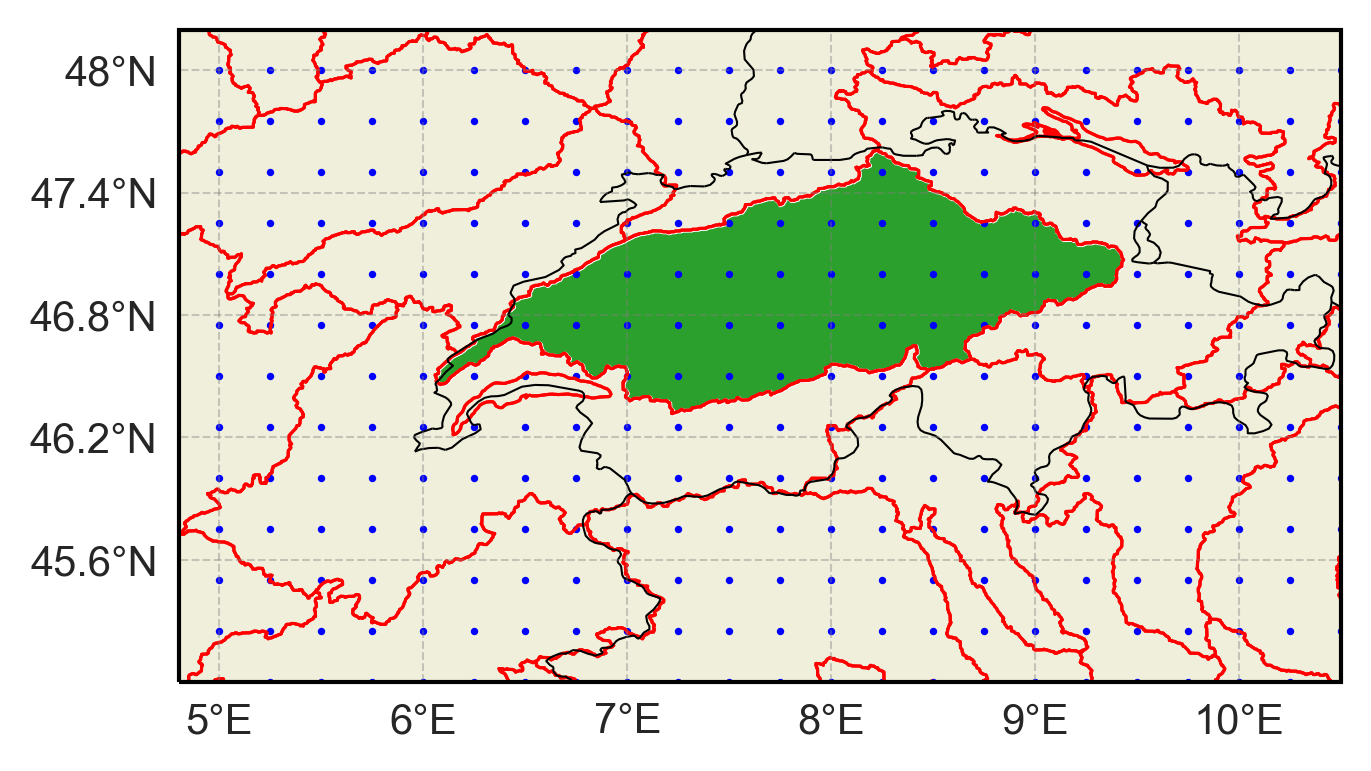

In [28]:
#Figure 1
#Plot to visualise catchment location
#Extract catchment and define plot boundaries
basin = 2060491750
bounds = hybas_data_gdf.loc[hybas_data_gdf.HYBAS_ID == basin].geometry.bounds
lo_min = math.floor(min(bounds.minx))
lo_max = math.ceil(max(bounds.maxx))
la_min = math.floor(min(bounds.miny))
la_max = math.ceil(max(bounds.maxy))

projection=ccrs.PlateCarree()
fig = plt.figure(figsize=(5,5),dpi=300)
ax = plt.axes(projection=projection)
ax.set_extent([lo_min-20,lo_max+10,la_min-20,la_max+10],projection) # Using catchments coordinates
ax.set_extent([4.8,10.5,45,48.2],projection) # Switzerland

hybas_data_gdf.loc[hybas_data_gdf.HYBAS_ID == basin].geometry.plot(ax=ax,color='tab:green')

data_gdf.geometry.centroid.plot(ax=ax,color='blue',markersize=0.6)

hybas_data_gdf.plot(ax=ax,color='none',edgecolor='red',linewidth=0.75,transform=projection)

ax.add_feature(cfeature.BORDERS.with_scale('10m'),linestyle='-',linewidth=0.5)
#ax.add_feature(cfeature.RIVERS.with_scale('10m'),linewidth=0.75,edgecolor='tab:blue')
ax.add_feature(cfeature.LAND.with_scale('10m'))

gl = ax.gridlines(crs=projection, draw_labels=True,linewidth=0.5, color='gray', alpha=0.4, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

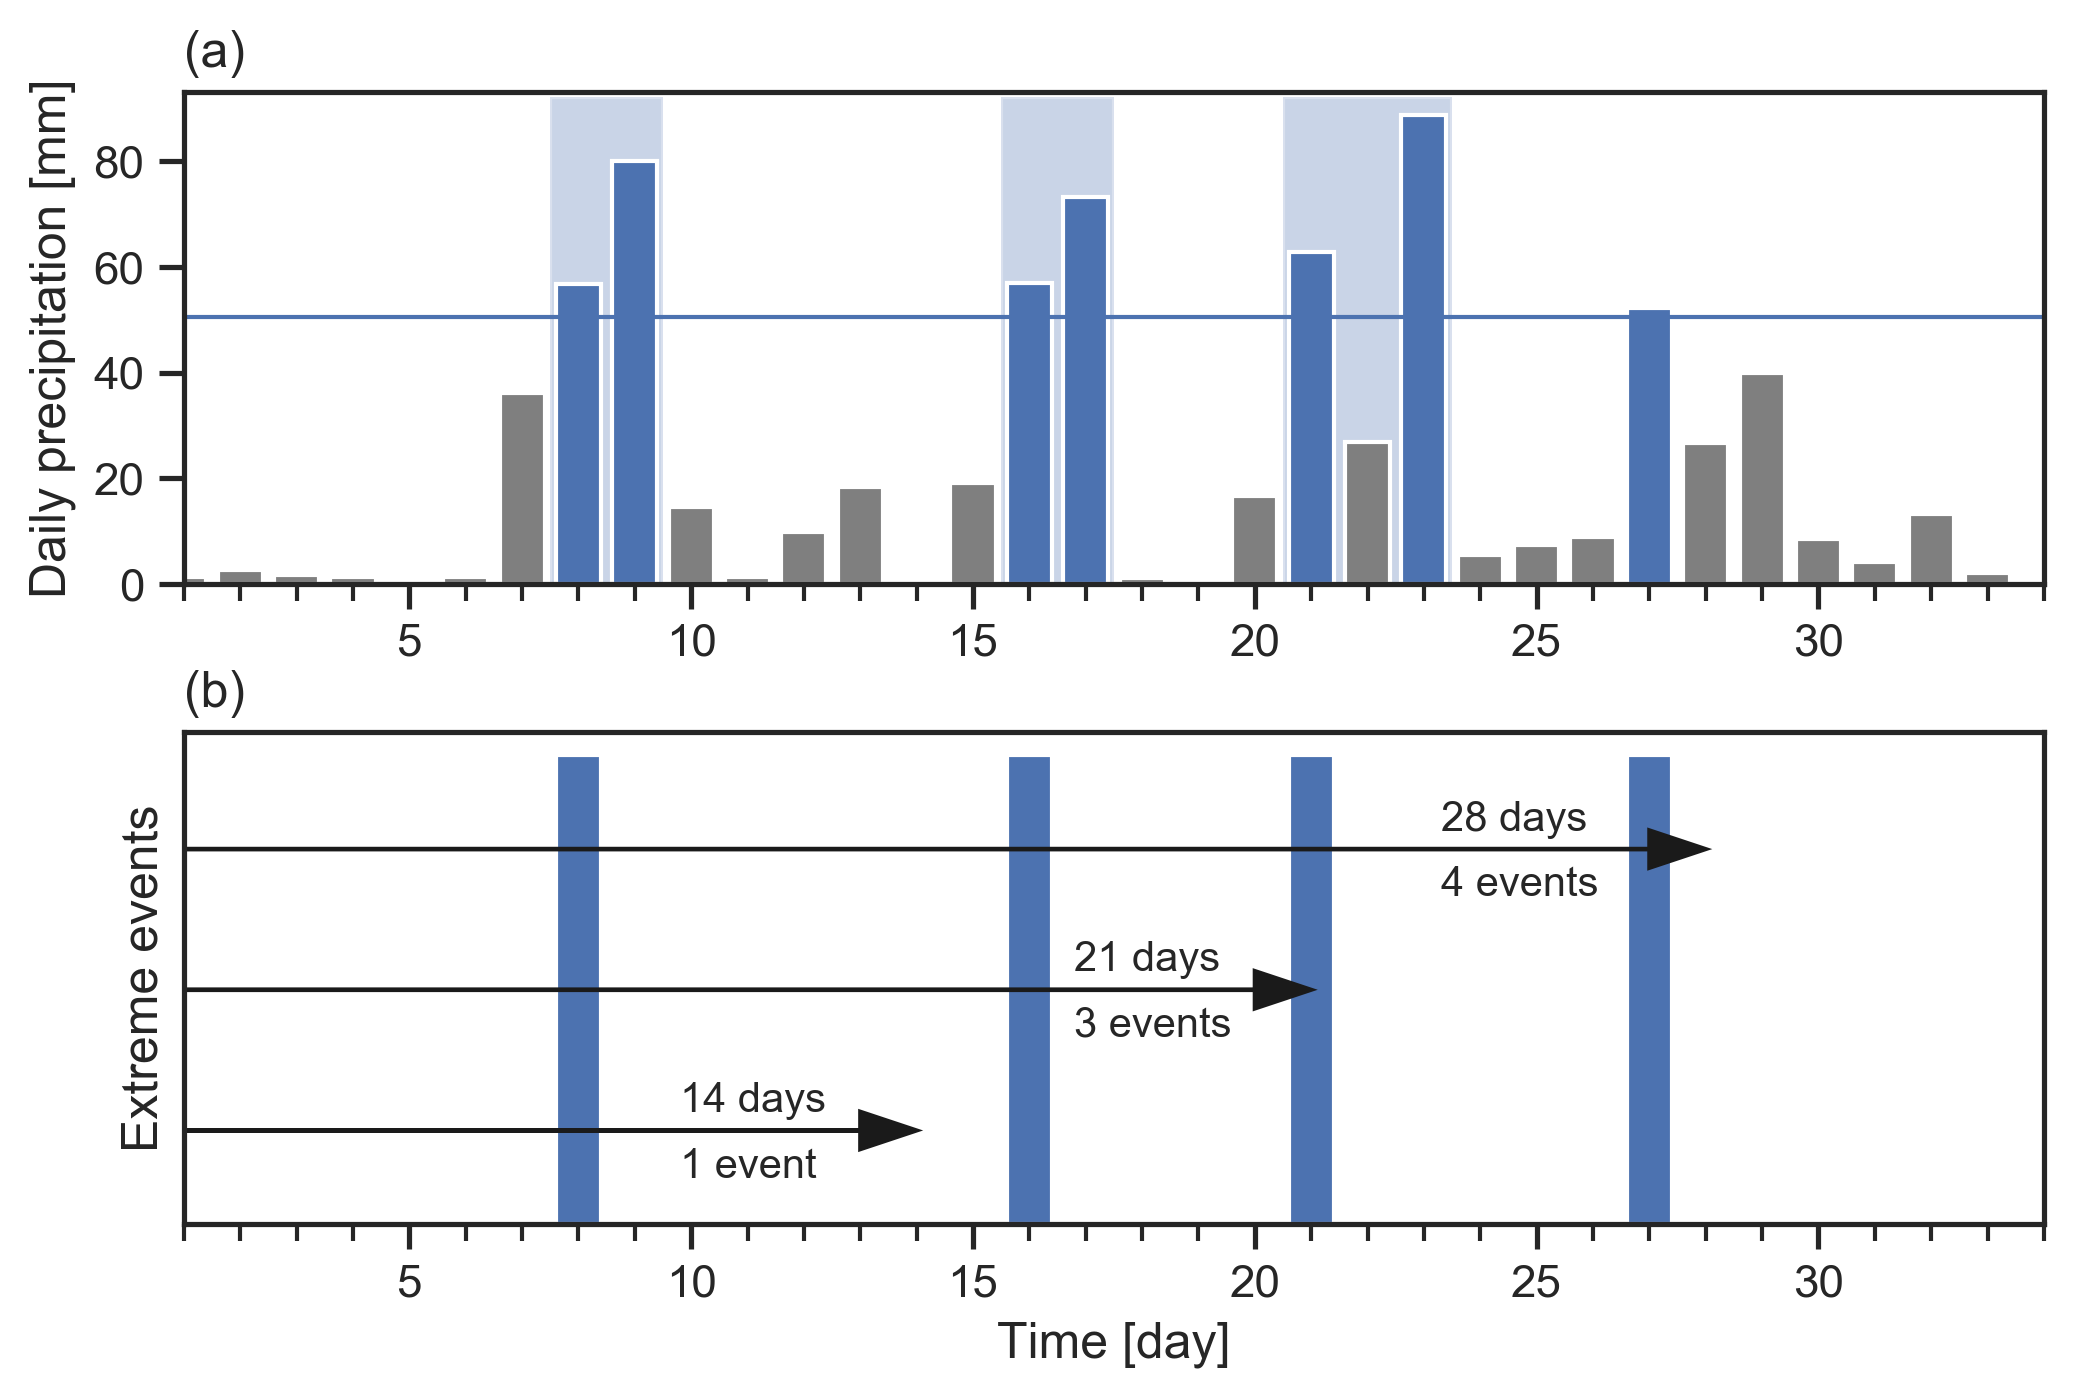

In [33]:
#Figure 3
# Event selection
event = sel.iloc[0]
# Create time slice from dates
event['daynum'] = event.time.dayofyear - 258
evt_data['daynum'] = evt_data.time.dt.dayofyear - 258
#eps['daynum'] = eps.time.dt.dayofyear - 258
start_time = event.time - pd.Timedelta(days=15)
end_time = event.time + pd.Timedelta(days=18)
start_day = event.daynum - 15
end_day = event.daynum + 18
time_slice = slice(start_time, end_time)
#Data for precipitations histogram and POT dates
pr_data = evt_data[(evt_data.time >= start_time) & (evt_data.time < end_time)]

fts = 12

#Change time series values for example
TP_change1 = -15
TP_change2 = 40
dates = ('1993-10-11','1993-10-12','1993-10-13','1993-10-14','1993-10-15','1993-10-16','1993-10-17','1993-10-18')
pr_data.loc[pr_data.time==dates[3],['TP']] += TP_change1
for i in range(len(dates)):
    pr_data.loc[pr_data.time == pd.to_datetime(dates[i]),[tpw]] += TP_change2*i

fig = plt.figure(figsize=(8,5),dpi=300,constrained_layout=True)
gs = gridspec.GridSpec(nrows=2, ncols=1,hspace=0.3)#,width_ratios=widths,height_ratios=heights)

#Precipitation Histogram
ax1 = fig.add_subplot(gs[0, 0])
event_POT = pr_data[pr_data.TP >= pr_data.TH]
event_others = pr_data[pr_data.TP < pr_data.TH]
delta = 0.5
plt.axvspan(event_POT['daynum'].iloc[0]-delta,event_POT['daynum'].iloc[1]+delta,alpha=0.3,ymax=0.99)
plt.axvspan(event_POT['daynum'].iloc[2]-delta,event_POT['daynum'].iloc[3]+delta,alpha=0.3,ymax=0.99)
plt.axvspan(event_POT['daynum'].iloc[4]-delta,event_POT['daynum'].iloc[5]+delta,alpha=0.3,ymax=0.99)
ax1.bar(event_POT.daynum, event_POT.TP, align='center')
ax1.bar(event_others.daynum, event_others.TP, align='center',color='tab:grey')
ax1.set_xlim(start_day, end_day)
ax1.set_title('(a)',loc='left')
plt.axhline(y=pr_data['TH'].iloc[0],linewidth=1)
plt.ylabel('Daily precipitation [mm]', fontsize=fts)

#Event Histogram
ax4 = fig.add_subplot(gs[1, 0])
ax4.bar(pr_data.daynum, pr_data[thn], align='center')
ax4.set_xlim(start_day, end_day)
ax4.tick_params(axis='y',which='both',labelleft=False,left=False)
ax4.set_title('(b)',loc='left')
plt.ylabel('Extreme events', fontsize=fts)
plt.xlabel('Time [day]', fontsize=fts)

x_tail = 0
y_tail = [0.2,0.5,0.8]
x_head = [13,20,27]
y_head = [0.2,0.5,0.8]
nudge = [-0.2,-0.2,-0.7]
dx = [x- x_tail for x in x_head] 
dy = tuple(map(lambda x, y: x - y, y_head, y_tail))
notes = ['14 days','21 days','28 days']
pks = ['1 event','3 events','4 events']
for i,j,k,l in zip(range(len(x_head)),range(len(notes)),range(len(pks)),range(len(nudge))):
    ax4.arrow(x_tail, y_tail[i], dx[i], dy[i], head_width=0.08, head_length=1, fc='k', ec='k')
    ax4.text(x_head[i]-3+nudge[l],y_head[i]+0.04,notes[j],horizontalalignment='left',fontsize=10)
    ax4.text(x_head[i]-3+nudge[l],y_head[i]-0.1,pks[j],horizontalalignment='left',fontsize=10)

# Make some ticks and tick labels
ax4.yaxis.set_major_locator(MultipleLocator(1))
ax4.xaxis.set_major_locator(MultipleLocator(5))
ax4.xaxis.set_minor_locator(MultipleLocator(1))
ax1.xaxis.set_major_locator(MultipleLocator(5))
ax1.xaxis.set_minor_locator(MultipleLocator(1))

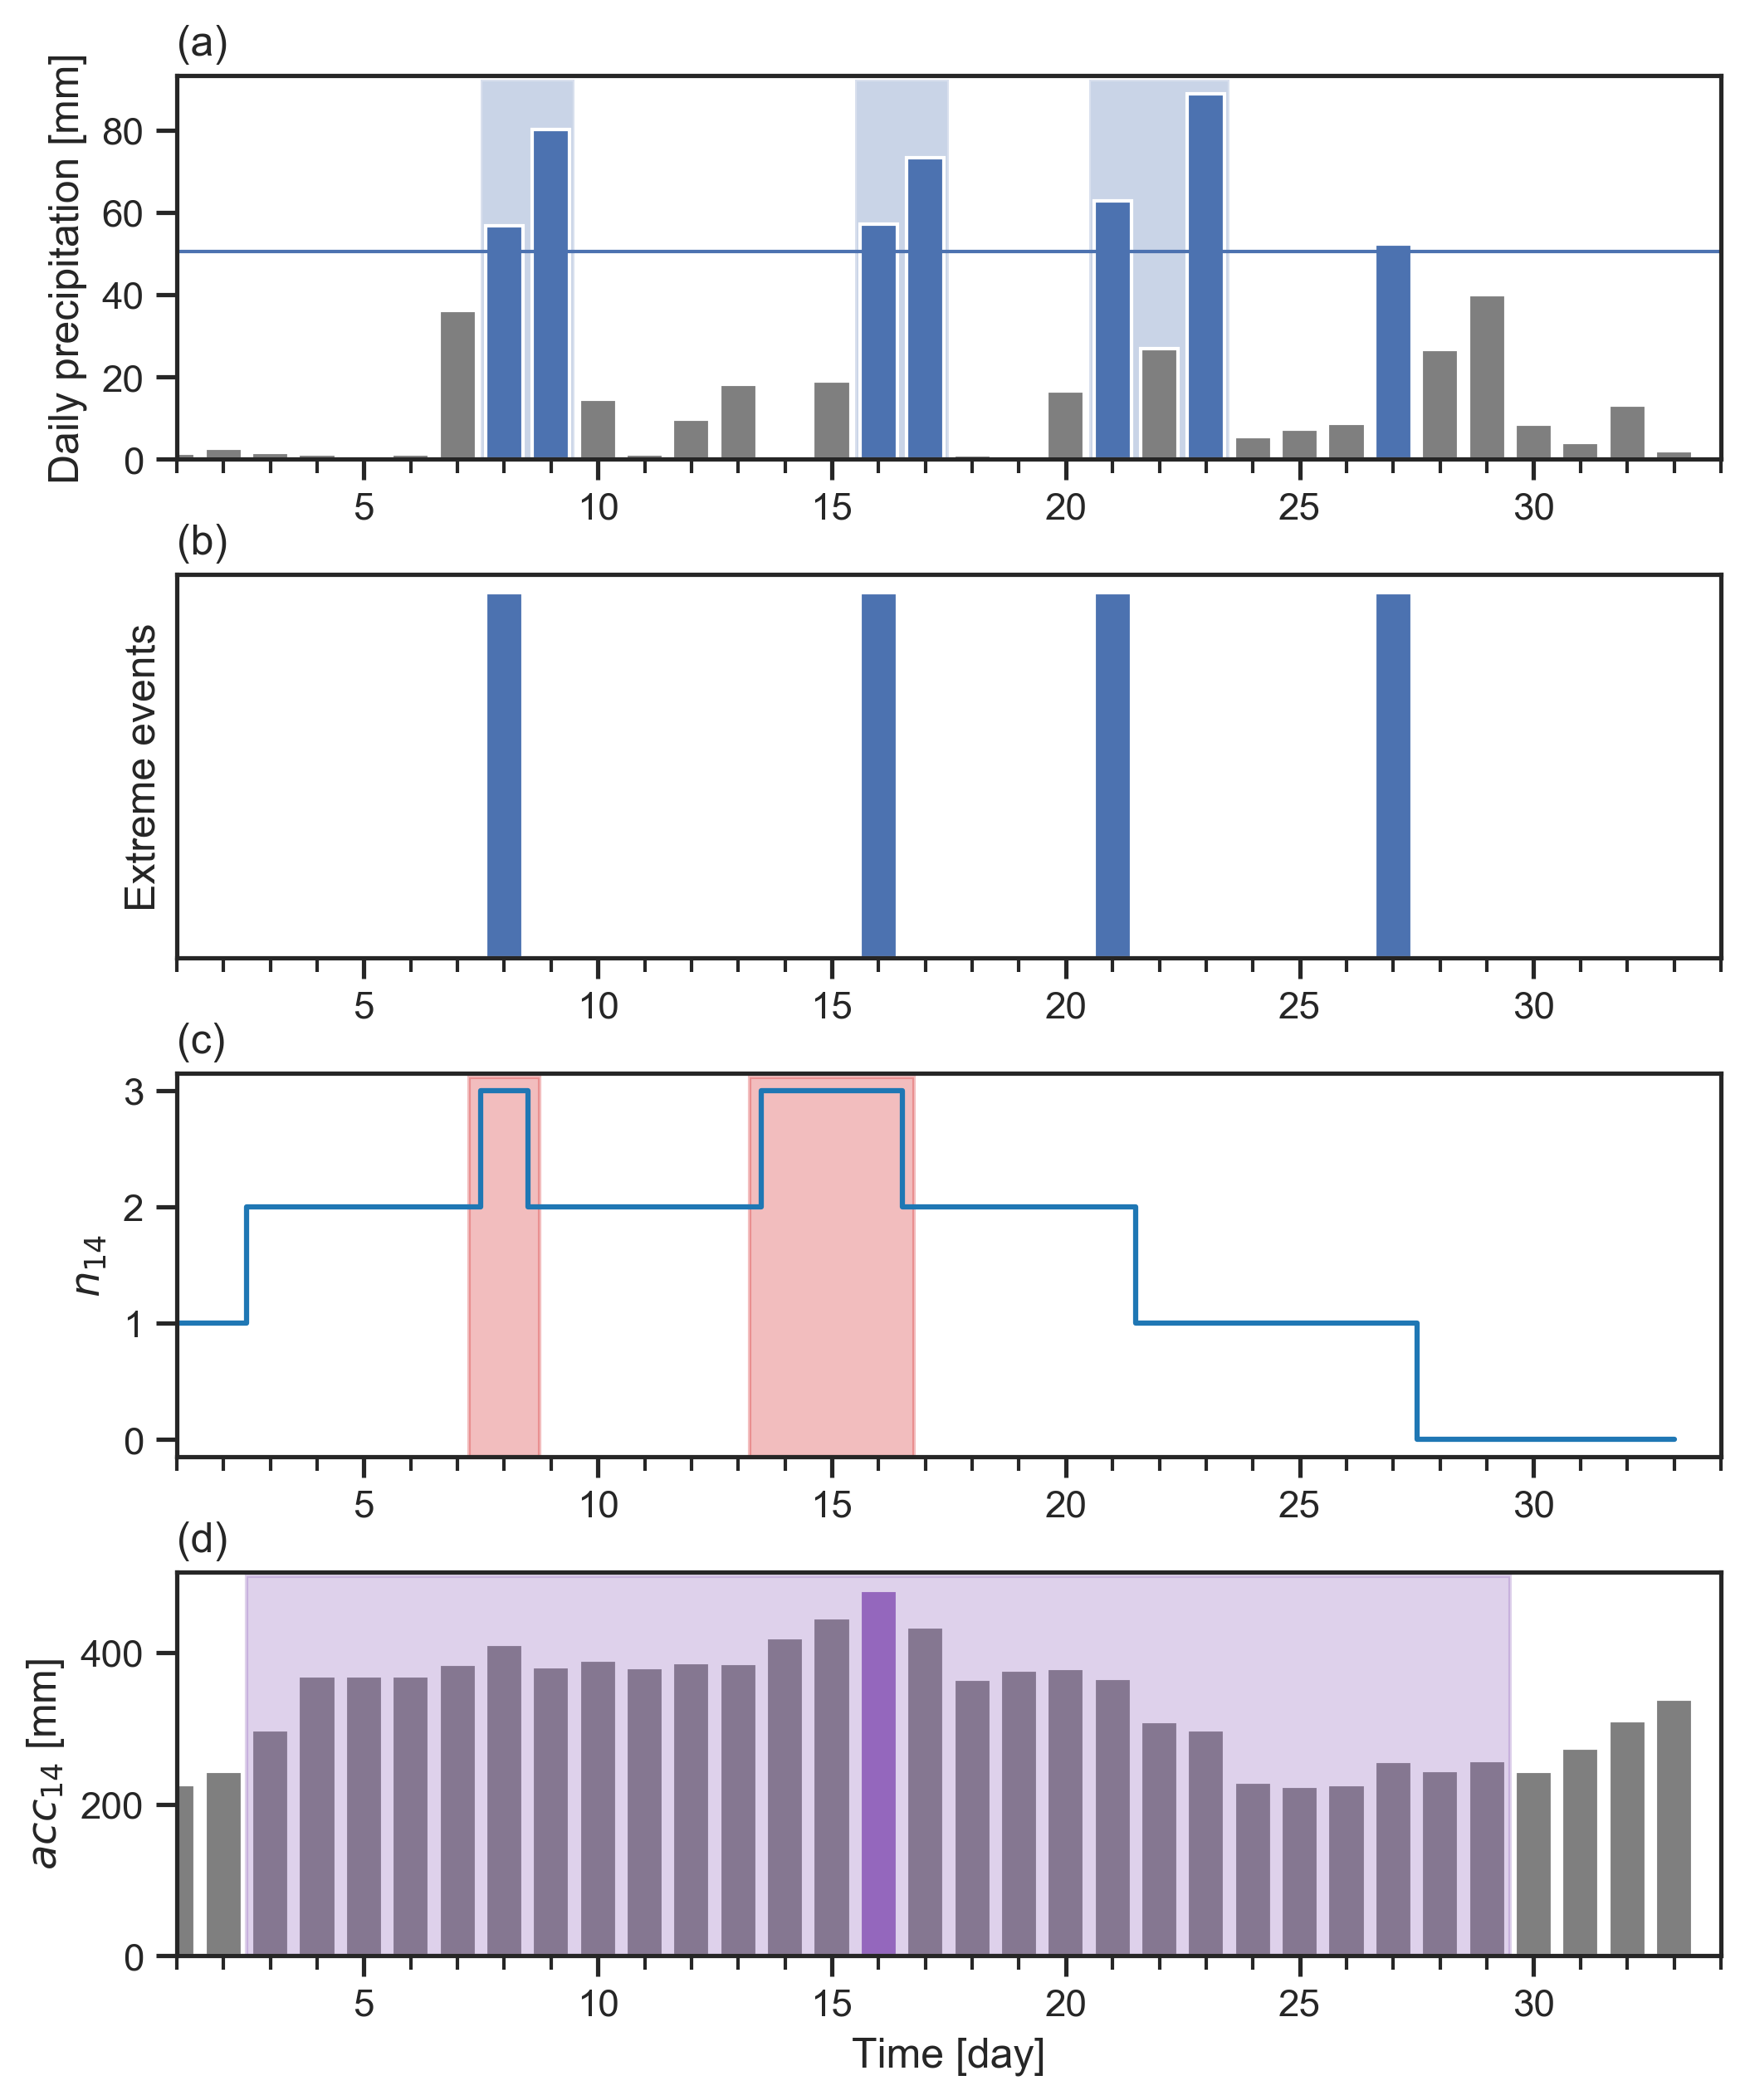

In [34]:
#Figure 4
# Event selection
event = sel.iloc[0]
# Create time slice from dates
event['daynum'] = event.time.dayofyear - 258
evt_data['daynum'] = evt_data.time.dt.dayofyear - 258
#eps['daynum'] = eps.time.dt.dayofyear - 258
start_time = event.time - pd.Timedelta(days=15)
end_time = event.time + pd.Timedelta(days=18)
start_day = event.daynum - 15
end_day = event.daynum + 18
time_slice = slice(start_time, end_time)
#Data for precipitations histogram and POT dates
pr_data = evt_data[(evt_data.time >= start_time) & (evt_data.time < end_time)]

fts = 12

#Change time series values for example
TP_change1 = -15
TP_change2 = 40
dates = ('1993-10-11','1993-10-12','1993-10-13','1993-10-14','1993-10-15','1993-10-16','1993-10-17','1993-10-18')
pr_data.loc[pr_data.time==dates[3],['TP']] += TP_change1
for i in range(len(dates)):
    pr_data.loc[pr_data.time == pd.to_datetime(dates[i]),[tpw]] += TP_change2*i

fig = plt.figure(figsize=(8,10),dpi=300,constrained_layout=True)
gs = gridspec.GridSpec(nrows=4, ncols=1,hspace=0.3)#,width_ratios=widths,height_ratios=heights)

#Precipitation Histogram
ax1 = fig.add_subplot(gs[0, 0])
event_POT = pr_data[pr_data.TP >= pr_data.TH]
event_others = pr_data[pr_data.TP < pr_data.TH]
delta = 0.5
plt.axvspan(event_POT['daynum'].iloc[0]-delta,event_POT['daynum'].iloc[1]+delta,alpha=0.3,ymax=0.99)
plt.axvspan(event_POT['daynum'].iloc[2]-delta,event_POT['daynum'].iloc[3]+delta,alpha=0.3,ymax=0.99)
plt.axvspan(event_POT['daynum'].iloc[4]-delta,event_POT['daynum'].iloc[5]+delta,alpha=0.3,ymax=0.99)
ax1.bar(event_POT.daynum, event_POT.TP, align='center')
ax1.bar(event_others.daynum, event_others.TP, align='center',color='tab:grey')
ax1.set_xlim(start_day, end_day)
ax1.set_title('(a)',loc='left')
plt.axhline(y=pr_data['TH'].iloc[0],linewidth=1)
plt.ylabel('Daily precipitation [mm]', fontsize=fts)

#Event Histogram
ax4 = fig.add_subplot(gs[1, 0])
ax4.bar(pr_data.daynum, pr_data[thn], align='center')
ax4.set_xlim(start_day, end_day)
ax4.tick_params(axis='y',which='both',labelleft=False,left=False)
ax4.set_title('(b)',loc='left')
plt.ylabel('Extreme events', fontsize=fts)

#PKw Histogram
delta = 0.75
ax3 = fig.add_subplot(gs[2, 0])
ax3.step(pr_data.daynum, pr_data[pkt],color='tab:blue',where='mid')
plt.axvspan(pr_data['daynum'].iloc[7]-delta,pr_data['daynum'].iloc[7]+delta,alpha=0.3,ymax=0.99,color='tab:red')
plt.axvspan(pr_data['daynum'].iloc[13]-delta,pr_data['daynum'].iloc[15]+delta,alpha=0.3,ymax=0.99,color='tab:red')
ax3.set_xlim(start_day, end_day)
ax3.set_title('(c)',loc='left')
#plt.axvspan(event.daynum-delta,event.daynum+delta,
#            alpha=0.3,ymax=0.99,color='tab:purple')
plt.ylabel('$n_{14}$', fontsize=fts)

#TPw Histogram
delta = 13.5
ax2 = fig.add_subplot(gs[3, 0])
ax2.bar(pr_data.daynum, pr_data[tpw], align='center',color='tab:grey')
ax2.bar(event.daynum, event.TPw14, align='center',color='tab:purple')
ax2.set_xlim(start_day, end_day)
ax2.set_title('(d)',loc='left')
plt.axvspan(event.daynum-delta,event.daynum+delta,alpha=0.3,ymax=0.99,color='tab:purple')
plt.ylabel('$acc_{14}$ [mm]', fontsize=fts)
plt.xlabel('Time [day]', fontsize=fts)

# Make some ticks and tick labels
ax4.yaxis.set_major_locator(MultipleLocator(1))
ax4.xaxis.set_major_locator(MultipleLocator(5))
ax4.xaxis.set_minor_locator(MultipleLocator(1))
ax1.xaxis.set_major_locator(MultipleLocator(5))
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax2.xaxis.set_major_locator(MultipleLocator(5))
ax2.xaxis.set_minor_locator(MultipleLocator(1))
ax3.xaxis.set_major_locator(MultipleLocator(5))
ax3.xaxis.set_minor_locator(MultipleLocator(1))
#years_fmt = mdates.DateFormatter('%j')
#ax1.xaxis.set_major_formatter(years_fmt)

In [28]:
### color bar ###
color_PV_C=[(119/255,151/255,254/255),(133/255,175/255,255/255),(175/255,202/255,255/255),
           (211/255,228/255,238/255),(255/255,222/255,158/255),(255/255,192/255,128/255),
           (255/255,133/255,60/255),(240/255,2/255,2/255),(255/255,122/255,1/255),
           (255/255,210/255,0/255),(254/255,249/255,0/255)]
color_PV_B=[(119/255,151/255,254/255),(133/255,175/255,255/255),(175/255,202/255,255/255),
           (211/255,228/255,238/255),(255/255,222/255,158/255),(255/255,192/255,128/255),
           (255/255,133/255,60/255),(240/255,2/255,2/255),(255/255,122/255,1/255),
           (255/255,210/255,0/255),(254/255,249/255,0/255),(174/255,237/255,0/255),
           (63/255,218/255,0/255)]
color_PV= [(127/255, 150/255, 255/255), (142/255, 178/255, 255/255), (181/255, 201/255, 255/255),
           (214/255, 226/255, 237/255),(242/255, 221/255, 160/255), (239/255, 193/255, 130/255),
           (242/255, 132/255, 68/255), (229/255, 0/255, 0/255), (1, 163/255, 10/255),
           (1, 249/255, 20/255), (172/255, 206/255, 100/255), (125/255, 190/255, 84/255)]

cmap_PV = mpl.colors.ListedColormap(color_PV_B)
cmap_PV_C = mpl.colors.ListedColormap(color_PV_C)
levels_PV = [-1,0, 0.2 ,0.5, 0.8, 1, 1.5, 2,3, 4 , 6 , 8, 10,12]
levels_PV_C = [-1,0, 0.2 ,0.5, 0.8, 1, 1.5, 2,3, 4 , 6 , 8]
norm_PV = mpl.colors.BoundaryNorm(levels_PV, cmap_PV.N)
norm_PV_C = mpl.colors.BoundaryNorm(levels_PV_C, cmap_PV_C.N)

color_IVT = ['white',(0.9288273740868896, 0.972318339100346, 0.6941637831603229),
 (0.7781776239907728, 0.9128642829680892, 0.7060976547481739),
 (0.4951787773933103, 0.8028604382929643, 0.733748558246828),
 (0.2526874279123414, 0.7114494425221068, 0.7683813917723953),
 (0.11410995770857363, 0.5647058823529412, 0.7510957324106113),
 (0.13361014994232986, 0.3647520184544406, 0.6569780853517878),
 (0.1419761630142253, 0.20144559784698193, 0.5739331026528259)]
cmap_IVT = mpl.colors.ListedColormap(color_IVT)

levels_IVT = [0,250,300,400,500,600,800,1000,1200]
levels_IVT_B = [0,100,150,200,250,300,350,400,500]
norm_IVT = mpl.colors.BoundaryNorm(levels_IVT, cmap_IVT.N)
norm_IVT_B = mpl.colors.BoundaryNorm(levels_IVT_B, cmap_IVT.N)
clevmslp = np.arange(800., 1120., 5)
kw_clabels = {'fontsize': 8, 'inline': True, 'inline_spacing': 12, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}
quiver_slice = slice(None, None, 7)
quiver_kwargs = {'pivot': 'mid', 'width': 0.0025,'headwidth':3.2,'headlength':3.5,'scale':1600,'alpha':0.6}
quiver_IVT_kwargs = {'pivot': 'mid', 'width': 0.0025,'headwidth':3.2,'headlength':3.5,'scale':15000,'alpha':1,
                    'color': 'darkorange'}

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5  # by changing radius we can zoom in/out
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

xc,yc = -7.27,39.69
xcp = 360+xc
red = sns.color_palette("tab10")[3]
#area = [-40, 50, yc+20, yc-25]
#area = [xc-60, xc+30, yc-20, yc+20]
area = [-90,30,20,70]
levPV = 1 #lev = 0 -> last level on levelsfile
isentrope = '320K'
projection=ccrs.PlateCarree()

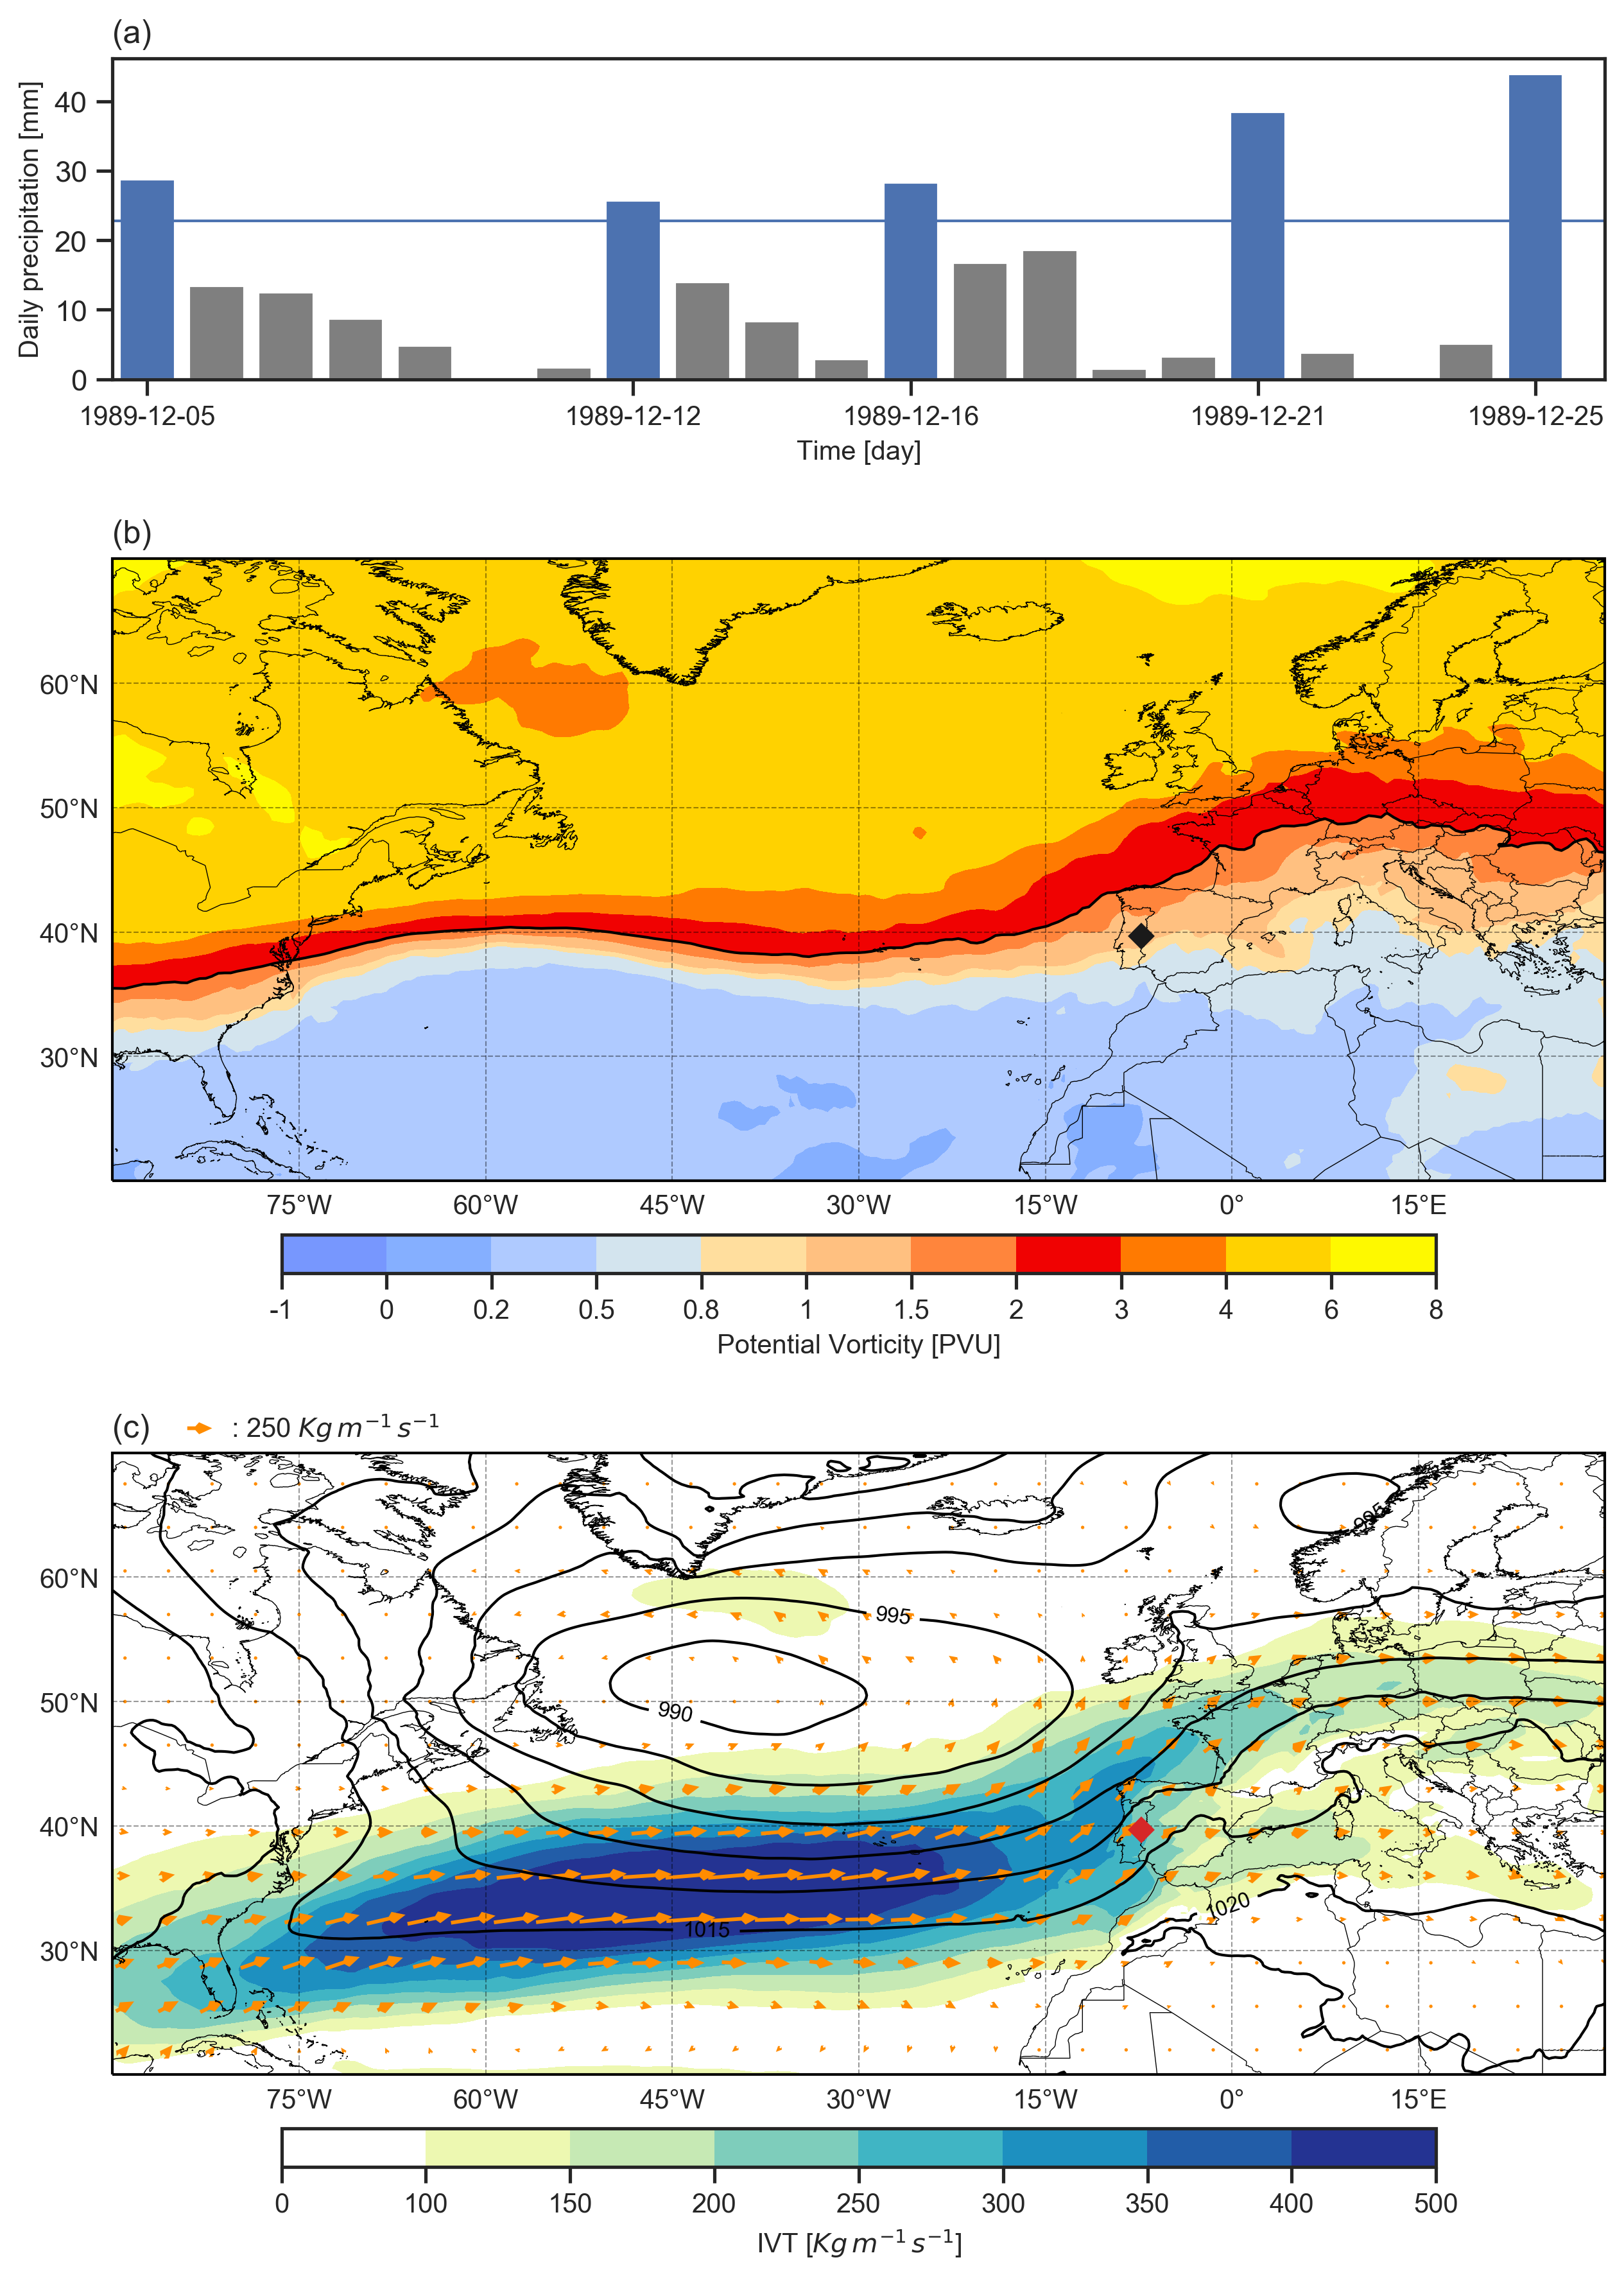

In [29]:
#Figure 11
projection=ccrs.PlateCarree()
fig = plt.figure(figsize=(10,14.5),dpi=300,constrained_layout=True)
heights = [2.5, 6, 6]
gs = gridspec.GridSpec(nrows=3, ncols=1,height_ratios=heights)#,width_ratios=widths,height_ratios=heights)

fts = 10
fts2 = 10

#Precipitation Histogram
ax1 = fig.add_subplot(gs[0, 0])
# Event selection
event = sel.iloc[0]
# Create time slice from dates
start_time = event.time - pd.Timedelta(hours=12)
end_time = event.time + pd.Timedelta(days=21)
time_slice = slice(start_time, end_time)
#Data for precipitations histogram and POT dates
pr_data = evt_data[(evt_data.time >= start_time) & (evt_data.time < end_time)]
event_POT = pr_data[pr_data.TP >= pr_data.TH]
event_others = pr_data[pr_data.TP < pr_data.TH]

ax1.bar(event_POT.time, event_POT.TP, align='center')
ax1.bar(event_others.time, event_others.TP, align='center',color='tab:grey')
ax1.set_xlim(start_time, end_time)
plt.axhline(y=pr_data['TH'].iloc[0],linewidth=1)
plt.ylabel('Daily precipitation [mm]', fontsize=fts)
plt.xlabel('Time [day]', fontsize=fts)
plt.xticks(event_POT.time, pd.to_datetime(event_POT['time']).dt.date, rotation=0,fontsize=fts)
ax1.set_title('(a)',loc='left')

#PV plot
ax2 = fig.add_subplot(gs[1, 0], projection=projection)

cbar = plt.cm.ScalarMappable(norm=norm_PV_C, cmap=cmap_PV_C)
PV = PV_comp.PV.isel(lev=levPV).squeeze()  # Add minus sign for SH
PV.where((PV > -1.0)).plot.contourf(ax=ax2, cmap=cmap_PV_C,
                                    transform=projection, norm=norm_PV_C, add_colorbar=False)
PV.plot.contour(ax=ax2, levels=[2.0], colors='black',
                transform=projection, linewidths=1, add_colorbar=False)
ax2.set_extent(area, projection)
ax2.set_title('')
ax2.add_feature(cfeature.COASTLINE.with_scale(
    '10m'), linestyle='-', linewidth=0.33)
ax2.add_feature(cfeature.BORDERS.with_scale(
    '10m'), linestyle='-', linewidth=0.33)
ax2.plot(xc, yc, 'kD')

ax2.set_title('(b)',loc='left')
gl = ax2.gridlines(crs=projection, draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.4, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': fts2}
gl.ylabel_style = {'size': fts2}
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylocator = mticker.FixedLocator([20, 30, 40, 50, 60, 70])

cb = fig.colorbar(cbar, pad=0.07, orientation='horizontal', format="%0.2f",
                  spacing='uniform', shrink=0.8, fraction=0.05, aspect=30,
                  ax=ax2)
cb.set_ticks(levels_PV_C)
cb.set_ticklabels(levels_PV_C)
cb.ax.tick_params(labelsize=fts2)
cb.set_label(label='Potential Vorticity [PVU]',size=fts2)

#IVT plot
ax3 = fig.add_subplot(gs[2, 0], projection=projection)
cbar = plt.cm.ScalarMappable(norm=norm_IVT_B, cmap=cmap_IVT)
Q_m_comp.QU.isel(lev=0).plot.contourf(ax=ax3, cmap=cmap_IVT,
                                         transform=projection, norm=norm_IVT_B, add_colorbar=False)
slp = SLP_comp.plot.contour(ax=ax3, levels=clevmslp, colors='black', linewidths=1,
                                        transform=projection)
IVT_arrows = ax3.quiver(QUint_comp.lon[::7], QUint_comp.lat[::7],
                       QUint_comp.QU.isel(lev=0, lon=quiver_slice, lat=quiver_slice),
                       QVint_comp.QV.isel(lev=0, lon=quiver_slice, lat=quiver_slice), **quiver_IVT_kwargs)
ax3.set_extent(area, projection)
ax3.add_feature(cfeature.COASTLINE.with_scale(
    '10m'), linestyle='-', linewidth=0.33)
ax3.add_feature(cfeature.BORDERS.with_scale(
    '10m'), linestyle='-', linewidth=0.33)
ax3.plot(xc, yc, marker='D', color=red)
ax3.clabel(slp, **kw_clabels)
ax3.set_title('(c)',loc='left')
gl = ax3.gridlines(crs=projection, draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.4, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax3.quiverkey(IVT_arrows, -82, 72, 250, ': 250 $Kg\,m^{-1}\,s^{-1}}$',
             coordinates='data', labelpos='E', zorder=3)
gl.xlabel_style = {'size': fts2}
gl.ylabel_style = {'size': fts2}
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylocator = mticker.FixedLocator([20, 30, 40, 50, 60, 70])

cb = fig.colorbar(cbar, pad=0.07, orientation='horizontal', format="%d",
                  spacing='uniform', shrink=0.8, fraction=0.05, aspect=30,
                  ax=ax3, label='IVT [$Kg\,m^{-1}\,s^{-1}$]')
cb.set_ticks(levels_IVT_B)
cb.set_ticklabels(levels_IVT_B)
cb.ax.tick_params(labelsize=fts2)
cb.set_label(label='IVT [$Kg\,m^{-1}\,s^{-1}$]',size=fts2)